Промежуточная аттестация

**Вопросы:**
1. Объясните, как вычисляется качество модели с задачей классификации: назовите основные и вторичные метрики, приведите пример.
2. Что такое тестовый набор данных (test set) и для чего он нужен?
3. В чем разница между параметром модели и гиперпараметром алгоритма обучения? Приведите примеры.
**Соревнование на кагле** - https://www.kaggle.com/competitions/titanic/
Соревнование простое: используйте машинное обучение для создания модели, которая предсказывает, кто из пассажиров выжил после кораблекрушения "Титаника".
Примерный план:
1. Знакомство с данными
2. EDA
3. Отбор признаков
4. Моделирование
5. Предсказание + итоги

# Ответы на вопросы:
1. Качество модели оценивается при помощи определенных метрик. В случае с задачей классификации, используются такие метрики как: accuracy, precision, recall, f1-score. Для вычисления этих метрик строится матрица ошибок.

  Accuracy - верные предсказания / все предсказания;
  Precision -  доля объектов, названных классификатором положительными и при этом действительно являющимися положительными;
  Recall - доля объектов положительного класса из всех объектов положительного класса;
  F1-score - среднее гармоническое precision и recall.


2. Тестовый набор данных представляет собой неизвестный модели набор. Он требуется для оценки того, как модель справляется с новыми и неизвестными ей данными.
3. Параметры модели это некоторые внутренние параметры, которые вычисляются по мере обучения модели. Гиперпараметры это параметры которые выставляются модели заранее. Гиперпараметрами являются, например, максимальная глубина дерева или скорость обучения. Параметрами являются коэффициенты прямой у линейной регресии или условие разделения ветвей дерева CART.

# Соревнование на kaggle

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
train = pd.read_csv('drive/MyDrive/train.csv')
test = pd.read_csv('drive/MyDrive/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Анализ данных

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Обнаружены явно неинформативные признаки, такие как: PassengerId, Name и Ticket.

In [62]:
train[train.Ticket.duplicated(keep=False)].shape

(344, 12)

Добавим новый признак Dublicated_Ticket для того, чтобы сохранить хоть какую-то информацию из признака Ticket.

In [63]:
train['Duplicated_Ticket'] = train.Ticket.duplicated(keep=False)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Duplicated_Ticket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False


In [64]:
train.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True) # Избавляемся от явно неинформативных столбцов
train.Cabin = train.Cabin[train.Cabin.notna()].apply(lambda x: x[0]) # Оставим лишь блок кают
train.Sex = train.Sex.apply(lambda x: 1 if x == 'male' else 0) # Заменим категориальный признак численным


train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Duplicated_Ticket
0,0,3,1,22.0,1,0,7.2500,NaN,S,False
1,1,1,0,38.0,1,0,71.2833,C,C,False
2,1,3,0,26.0,0,0,7.9250,NaN,S,False
3,1,1,0,35.0,1,0,53.1000,C,S,True
4,0,3,1,35.0,0,0,8.0500,NaN,S,False


<Axes: xlabel='Cabin', ylabel='Count'>

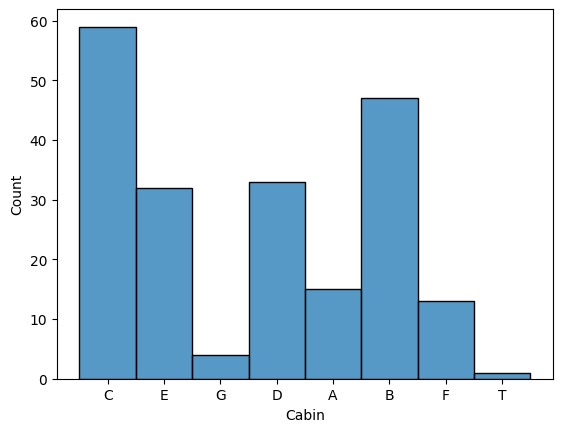

In [65]:
sns.histplot(train, x='Cabin')

In [66]:
train[train.Cabin == 'T']

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Duplicated_Ticket
339,0,1,1,45.0,0,0,35.5,T,S,False


Обнаружен странный блок кают "T". Заменим его на чаще всего встречающийся блок соответствующий PClass, а также заполним пропущенные значения Cabin.

In [67]:
train.Cabin[train.Pclass == 1] = train.Cabin[train.Pclass == 1].fillna(train.Cabin[train.Pclass == 1].mode()[0])
train.Cabin[train.Pclass == 2] = train.Cabin[train.Pclass == 2].fillna(train.Cabin[train.Pclass == 2].mode()[0])
train.Cabin[train.Pclass == 3] = train.Cabin[train.Pclass == 3].fillna(train.Cabin[train.Pclass == 3].mode()[0])
train.Cabin[train.Cabin == 'T'] = train.Cabin[train.Pclass == 1].mode()[0]
train.isna().sum()

<ipython-input-67-3d2189c23505>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Cabin[train.Pclass == 1] = train.Cabin[train.Pclass == 1].fillna(train.Cabin[train.Pclass == 1].mode()[0])
<ipython-input-67-3d2189c23505>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Cabin[train.Pclass == 2] = train.Cabin[train.Pclass == 2].fillna(train.Cabin[train.Pclass == 2].mode()[0])
<ipython-input-67-3d2189c23505>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Cabin,0
Embarked,2
Duplicated_Ticket,0


In [68]:
train.Embarked.mode()

,Embarked
0,S


In [69]:
train.Embarked.fillna('S', inplace=True) # Заполним место посадки чаще всего встречающимся значением
train.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Cabin,0
Embarked,0
Duplicated_Ticket,0


<Axes: xlabel='Fare', ylabel='Age'>

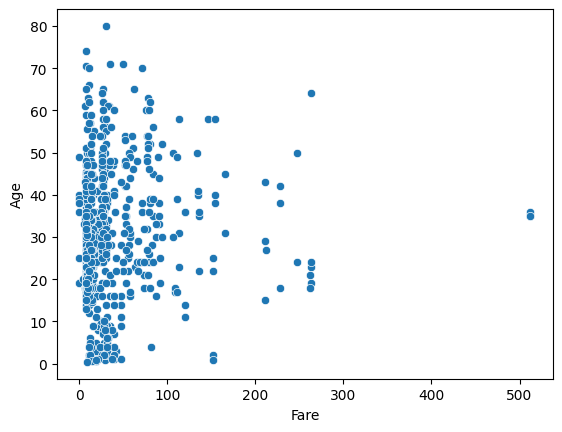

In [70]:
sns.scatterplot(train, x='Fare', y='Age')

Никаких зависимостей у признака Age не обнаружено. Заполним Age средним значением.

In [71]:
train.Age.fillna(train.Age.mean(), inplace=True)
train.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Cabin,0
Embarked,0
Duplicated_Ticket,0


In [72]:
train = pd.get_dummies(train) # Разобьем категориальные признаки на отдельные столбцы
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Duplicated_Ticket,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,False,False,False,False,False,False,True,False,False,False,True
1,1,1,0,38.0,1,0,71.2833,False,False,False,True,False,False,False,False,True,False,False
2,1,3,0,26.0,0,0,7.9250,False,False,False,False,False,False,True,False,False,False,True
3,1,1,0,35.0,1,0,53.1000,True,False,False,True,False,False,False,False,False,False,True
4,0,3,1,35.0,0,0,8.0500,False,False,False,False,False,False,True,False,False,False,True


<Axes: >

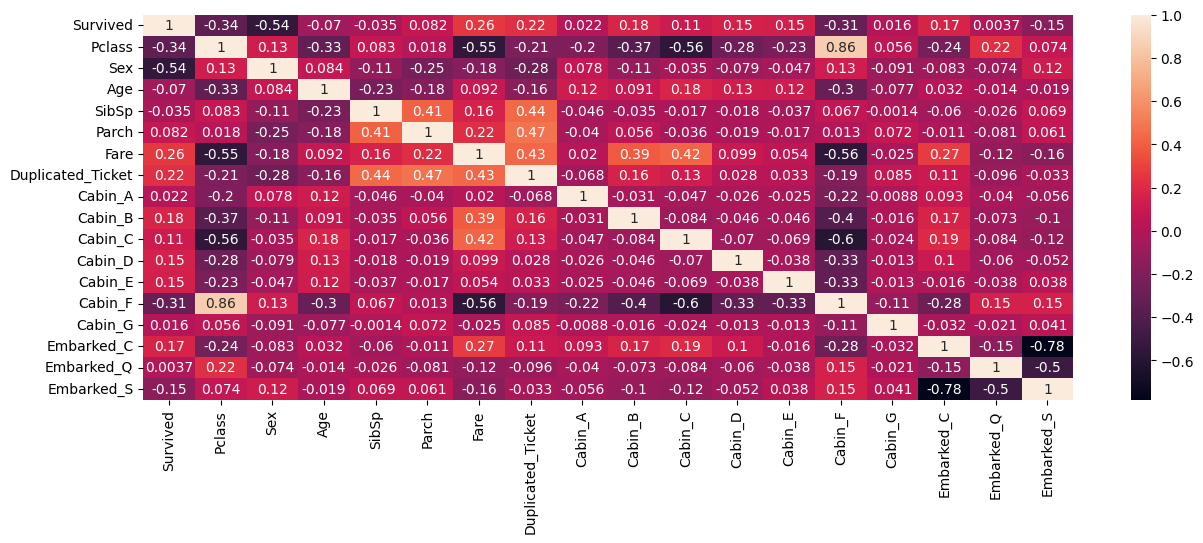

In [73]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(train.corr(), annot=True, ax=ax)

## Обучение и предсказание

Создадим тренировочный и тестовый набор данных.

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived', axis=1), train.Survived, test_size=0.1, random_state=42)

print(y_train.shape)
print(y_test.shape)

(801,)
(90,)


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Создадим словарь с несколькими моделями для удобства тестирования.

In [75]:
Models = {
  'LogisticRegression' : LogisticRegression(max_iter=1000, random_state=42),
  'DecisionTreeClassifier' : DecisionTreeClassifier(max_depth=5, random_state=42),
  'RandomForestClassifier' : RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42),
  'GradientBoostingClassifier': GradientBoostingClassifier(max_depth=3, random_state=42),
  'HistGradientBoostingClassifier': HistGradientBoostingClassifier(max_depth=3, random_state=42)

}

Вычислим метрики у каждой модели.

In [76]:
ModelName = []
ModelAccuracy = []
for nameModel, model in Models.items():
    model.fit(X_train, y_train)
    ModelName.append(nameModel)
    y_pred = model.predict(X_test)
    ModelAccuracy.append([
        accuracy_score(y_test,y_pred)
        ,precision_score(y_test,y_pred)
        ,recall_score(y_test,y_pred)
        ,f1_score(y_test,y_pred)
    ])

In [77]:
Model_accuracy = pd.DataFrame(ModelAccuracy,index=ModelName,columns = ['Accuracy','Precision','Recall','F1 Score'])
Model_accuracy

,Accuracy,Precision,Recall,F1 Score
LogisticRegression,0.822222,0.763158,0.805556,0.783784
DecisionTreeClassifier,0.755556,0.769231,0.555556,0.645161
RandomForestClassifier,0.844444,0.843750,0.750000,0.794118
GradientBoostingClassifier,0.822222,0.777778,0.777778,0.777778
HistGradientBoostingClassifier,0.844444,0.789474,0.833333,0.810811


Лучшими моделями по соревновательному признаку accuracy оказались RandomForestClassifier и HistGradientBoostingClassifier.

## Отправка решения

Подготовим тестовые данные kaggle аналогично тренировочному набору.

In [78]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [79]:
test['Duplicated_Ticket'] = test.Ticket.duplicated(keep=False)
test.drop(['Name', 'Ticket'], axis=1, inplace=True)
test.Cabin = test.Cabin[test.Cabin.notna()].apply(lambda x: x[0])
test.Sex = test.Sex.apply(lambda x: 1 if x == 'male' else 0)

test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Duplicated_Ticket
0,892,3,1,34.5,0,0,7.8292,NaN,Q,False
1,893,3,0,47.0,1,0,7.0000,NaN,S,False
2,894,2,1,62.0,0,0,9.6875,NaN,Q,False
3,895,3,1,27.0,0,0,8.6625,NaN,S,False
4,896,3,0,22.0,1,1,12.2875,NaN,S,False


<Axes: xlabel='Cabin', ylabel='Count'>

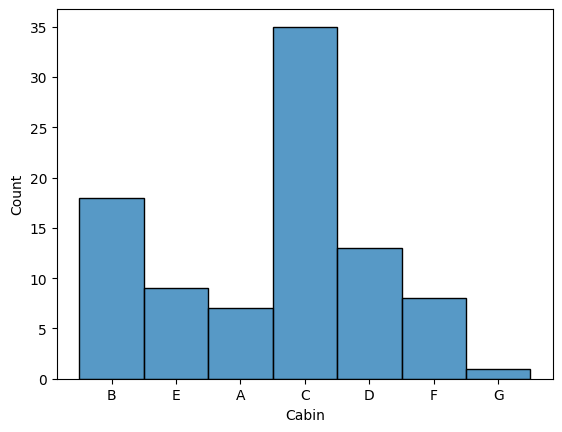

In [80]:
sns.histplot(test, x='Cabin')

In [81]:
test.Cabin[test.Pclass == 1] = test.Cabin[test.Pclass == 1].fillna(test.Cabin[test.Pclass == 1].mode()[0])
test.Cabin[test.Pclass == 2] = test.Cabin[test.Pclass == 2].fillna(test.Cabin[test.Pclass == 2].mode()[0])
test.Cabin[test.Pclass == 3] = test.Cabin[test.Pclass == 3].fillna(test.Cabin[test.Pclass == 3].mode()[0])

test.isna().sum()

<ipython-input-81-7208343d8a07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.Cabin[test.Pclass == 1] = test.Cabin[test.Pclass == 1].fillna(test.Cabin[test.Pclass == 1].mode()[0])
<ipython-input-81-7208343d8a07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.Cabin[test.Pclass == 2] = test.Cabin[test.Pclass == 2].fillna(test.Cabin[test.Pclass == 2].mode()[0])
<ipython-input-81-7208343d8a07>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

,0
PassengerId,0
Pclass,0
Sex,0
Age,86
SibSp,0
Parch,0
Fare,1
Cabin,0
Embarked,0
Duplicated_Ticket,0


Тестовые данные содержат 1 пропуск в признаке Fare.

In [82]:
test[test.Fare.isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Duplicated_Ticket
152,1044,3,1,60.5,0,0,NaN,F,S,False


In [83]:
test.Age.fillna(test.Age.mean(), inplace=True)
test.Fare.fillna(test[test.Pclass == 3].Fare.mean(), inplace=True) # Заполним пустое значение средним по классу
test.isna().sum()

,0
PassengerId,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Cabin,0
Embarked,0
Duplicated_Ticket,0


In [84]:
test = pd.get_dummies(test)
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Duplicated_Ticket,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Embarked_C,Embarked_Q,Embarked_S
0,892,3,1,34.5,0,0,7.8292,False,False,False,False,False,False,True,False,False,True,False
1,893,3,0,47.0,1,0,7.0000,False,False,False,False,False,False,True,False,False,False,True
2,894,2,1,62.0,0,0,9.6875,False,False,False,False,False,False,True,False,False,True,False
3,895,3,1,27.0,0,0,8.6625,False,False,False,False,False,False,True,False,False,False,True
4,896,3,0,22.0,1,1,12.2875,False,False,False,False,False,False,True,False,False,False,True


Отправим на проверку 2 лучшие модели.

In [85]:
hgbc =  HistGradientBoostingClassifier(max_depth=3)

hgbc.fit(train.drop('Survived', axis=1), train.Survived)
pred = hgbc.predict(test.drop('PassengerId', axis=1))

df = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred})
df.to_csv('File.csv', index=False)

In [94]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=5)

rfc.fit(train.drop('Survived', axis=1), train.Survived)
pred = rfc.predict(test.drop('PassengerId', axis=1))

df = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred})
df.to_csv('file.csv', index=False)

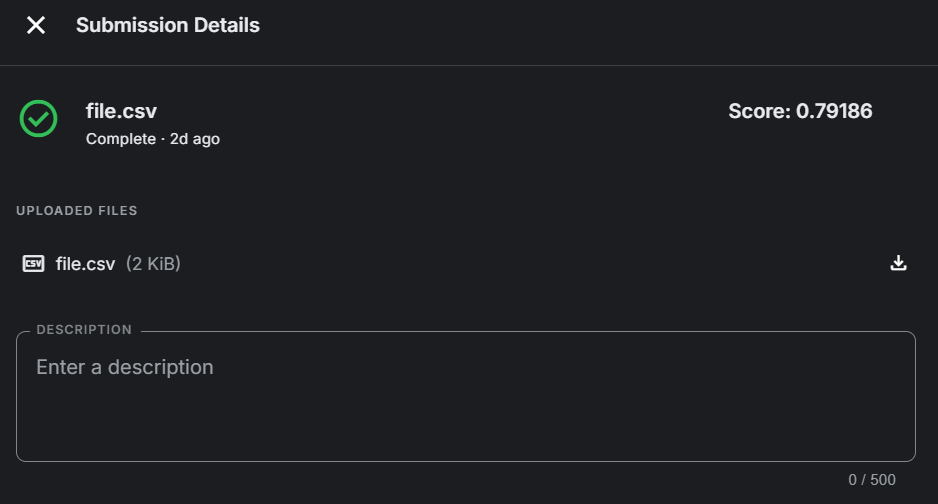